# Network Analysis Project

In [1]:
%matplotlib inline

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb
import math
import seaborn as sns
import pandas as pd
import copy as cp
from collections import deque
import random as rnd
rnd.seed(22)

## Graph input

In [2]:
G = nx.read_edgelist("email-Eu-core.txt")

## 1. Number of **nodes** and **edges**

In [3]:
num_nodes = len(G.nodes)
print("Number of nodes", num_nodes)

Number of nodes 1005


In [4]:
num_edges = len(G.edges)
print("Number of edges", num_edges)

Number of edges 16706


## 2. Draw the graph

/home/quan/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


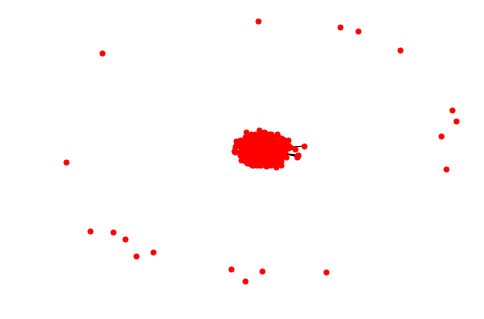

In [5]:
pos=nx.spring_layout(G)  
nx.draw(G,pos, node_size = 25)

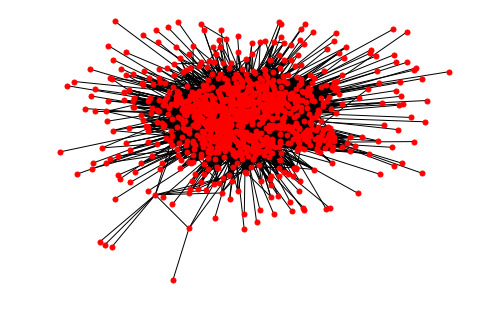

In [6]:
subgraphs = list(nx.connected_component_subgraphs(G))
for g in subgraphs:
    if len(list(g.nodes())) == 1:
        G.remove_nodes_from(g.nodes())
nx.draw(G, node_size = 25)

In [7]:
G = nx.read_edgelist("email-Eu-core.txt")

## 3. Draw the histogram of degrees. Compare the distribution with the distribution for a random graph having the same average degree. Discuss the results.

### Real network

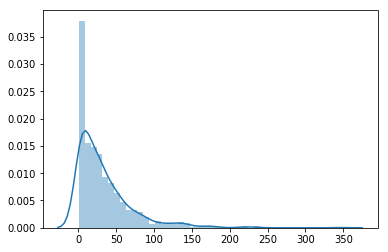

In [8]:
degrees = list(map(lambda x: x[1], list(nx.degree(G))))
sns.distplot(degrees)

In [9]:
print("Average degree", np.mean(degrees))

Average degree 33.245771144278606


### Random network

In [10]:
average_degree = np.mean(degrees)
p = average_degree / (num_nodes - 1)
RG = nx.gnp_random_graph(num_nodes, p)

In [11]:
print(p)

0.03311331787278746


In [12]:
print("Number of edges", len(list(RG.edges())))

Number of edges 16448


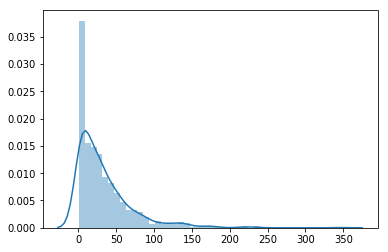

In [13]:
r_degrees = list(map(lambda x: x[1], list(nx.degree(RG))))
sns.distplot(degrees)

In [14]:
print("Average degree", np.mean(r_degrees))

Average degree 32.73233830845771


## 4. Draw the histogram of clustering coefficient, and the average clustering coefficient. Compare it with the one of a random graph and discuss the results.

### Real Network

In [15]:
G_cc_values = list(nx.clustering(G).values())
avg_G_cc_value = np.mean(G_cc_values)
print("Average clustering coefficient", avg_G_cc_value)

Average clustering coefficient 0.39935496642215434


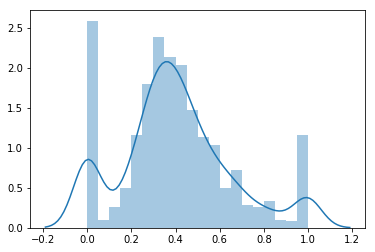

In [16]:
sns.distplot(G_cc_values)

### Random network

In [17]:
RG_cc_values = list(nx.clustering(RG).values())
avg_RG_cc_value = np.mean(RG_cc_values)
print("Average clustering coefficient", avg_RG_cc_value)

Average clustering coefficient 0.03275813423428659


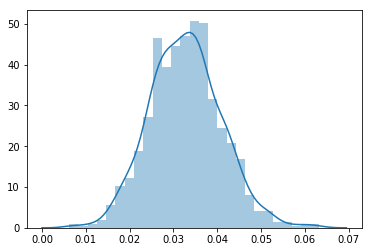

In [18]:
sns.distplot(RG_cc_values)

## 5. Draw the histogram of distances in the graphs, the diameter and the average distance. Compare with random graphs and discuss the results.

### Real Network

In [19]:
# we need to check if the graph is connected
print("Graph is connected:", nx.is_connected(G))

Graph is connected: False


Because the graph is not connected, we will find all the connected component and then compute the diameter of each connected component

In [20]:
connected_components = nx.connected_component_subgraphs(G)
diameters = []
count = 0
for com in connected_components:
    d = nx.diameter(com)
    diameters.append(d)
    count += 1
print("Diameters", diameters)
print("Found", count, "connected component")

Diameters [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Found 20 connected component


In [21]:
paths = nx.shortest_path_length(G)
total = 0
count = 0
distances = []
for node, lengths in paths:        
    values = lengths.values() 
    count += len(values) - 1 # -1 to not count the path to itself
    total += sum(values)
    distances = distances + list(values)
    
# note that we add the distance of each path twice and we also count each path twice
# Therefore when we compute total / count the result is correct
print("Average distance", total / count)

Average distance 2.586933824816466


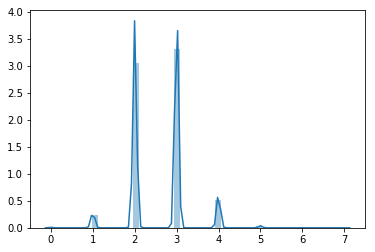

In [22]:
# note that we add the distance of each path twice and we also count each path twice
# when we plot the distribution, all the distances are normalized => the result is correct
sns.distplot(distances)

### Random Network

In [23]:
# We need to check if the graph is connected
print("Graph is connected:", nx.is_connected(RG))

Graph is connected: True


In [24]:
print("Diameter", nx.diameter(RG))

Diameter 3


In [25]:
paths = nx.shortest_path_length(RG)
total = 0
count = 0
distances = []
for node, lengths in paths:        
    values = lengths.values() 
    count += len(values) - 1 # -1 to not count the path to itself
    total += sum(values)
    distances = distances + list(values)
    
# note that we add the distance of each path twice and we also count each path twice
# Therefore when we compute total / count the result is correct
print("Average distance", total / count)

Average distance 2.30017640879269


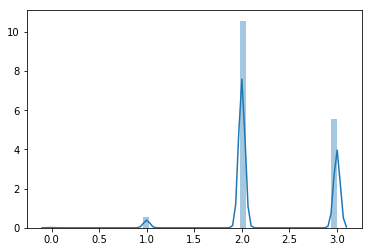

In [26]:
# note that we add the distance of each path twice and we also count each path twice
# when we plot the distribution, all the distances are normalized => the result is correct
sns.distplot(distances)

## 6. Analyze the degree correlations of the graph.

### Real Network

In [27]:
# Degree Assortativity
nx.degree_assortativity_coefficient(G)

-0.01099049062793108

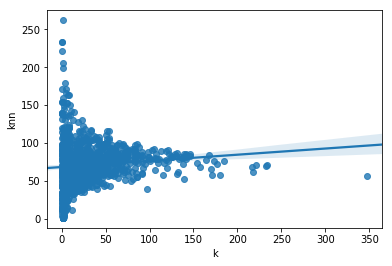

In [28]:
knns = nx.average_neighbor_degree(G)
degrees = nx.degree(G)
dc = []
for node in knns:
    dc.append([degrees[node], knns[node]])
data = pd.DataFrame(dc)
data.columns = ["k", "knn"]
sns.regplot(x="k", y="knn", data=data)

### Random Network

In [29]:
# Degree Assortativity
nx.degree_assortativity_coefficient(RG)

-0.0015122358161471883

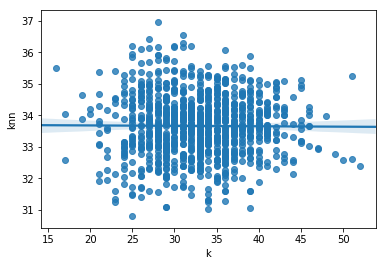

In [30]:
knns = nx.average_neighbor_degree(RG)
degrees = nx.degree(RG)
dc = []
for node in knns:
    dc.append([degrees[node], knns[node]])
data = pd.DataFrame(dc)
data.columns = ["k", "knn"]
sns.regplot(x="k", y="knn", data=data)

## Detect the communities in the graph, and discuss the results

In [31]:
G = nx.read_edgelist("email-Eu-core.txt")
communities = [list(c) for c in nx.algorithms.community.modularity_max.greedy_modularity_communities(G)]

clustering = []
avg_distances = []
diameters = []
d = dict()
for c in communities:
    if len(c) in d:
        d[len(c)] += 1
    else:
        d[len(c)] = 1
    if len(c) > 1:
        subgraph = G.subgraph(c)   
        clustering.append(nx.average_clustering(subgraph))
        avg_distances.append(nx.average_shortest_path_length(subgraph))
        diameters.append(nx.diameter(subgraph))
print("Number of communities:", len(communities))
print(d)
print("Average clusterings", clustering)
print("Average distances", avg_distances)
print("diameters", diameters)

Number of communities: 44
{368: 1, 321: 1, 103: 1, 89: 1, 58: 1, 9: 3, 2: 3, 1: 33}
Average clusterings [0.45288246251167175, 0.4332951307815015, 0.504975945622249, 0.5138986577053216, 0.701463974071869, 0.5814814814814815, 0.30687830687830686, 0.0, 0.0, 0.0, 0.0]
Average distances [2.4019962089799787, 2.3896806853582553, 2.190938511326861, 1.8730847803881512, 2.3914095583787054, 1.6388888888888888, 1.8888888888888888, 2.388888888888889, 1.0, 1.0, 1.0]
diameters [5, 5, 5, 4, 6, 3, 3, 5, 1, 1, 1]


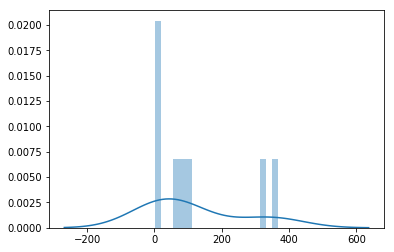

In [32]:
# size distribution
sns.distplot(list(d.keys()), bins=20)

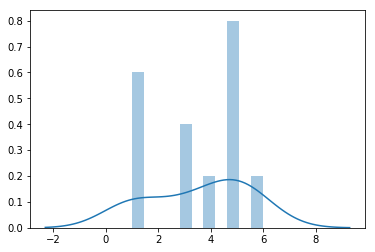

In [33]:
# diameters distribution
sns.distplot(diameters, bins=11)

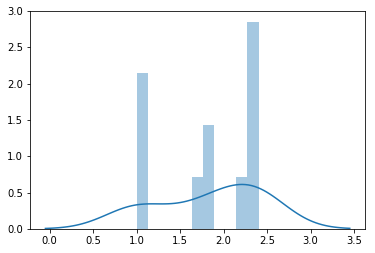

In [34]:
# Average distance distribution
sns.distplot(avg_distances, bins=11)

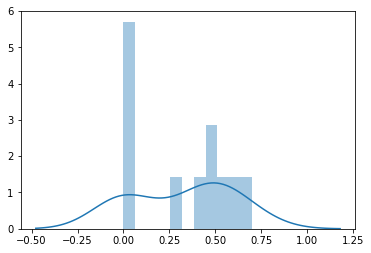

In [35]:
# clustering coefficient distribution
sns.distplot(clustering, bins=11)

#### Ground-truth communities

In [36]:
# ground-truth communities
deps = dict()
length = dict()
gt_coms = pd.read_csv("email-Eu-core-department-labels.txt", delimiter=" ").values
for row in gt_coms:
    dep = str(row[1])
    node = str(row[0])
    if dep in deps:
        deps[dep].append(node)
    else:
        deps[dep] = [node]
for dep in deps:
    length[dep] = len(deps[dep])

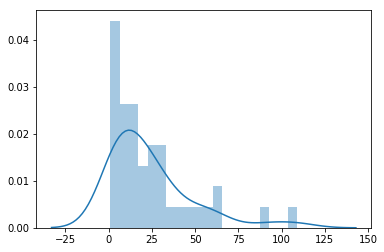

In [37]:
# size distribution
sns.distplot(list(length.values()), bins=20)

In [38]:
G = nx.read_edgelist("email-Eu-core.txt")
clustering = []
avg_distances = []
diameters = []
subgraphs_not_connected = 0
communities = list(deps.values())
for c in communities:
    
    if len(c) > 1:
        subgraph = G.subgraph(c)  
        
        if nx.is_connected(subgraph):
            clustering.append(nx.average_clustering(subgraph))
            avg_distances.append(nx.average_shortest_path_length(subgraph))
            diameters.append(nx.diameter(subgraph))
        else:
            subgraphs_not_connected += 1
print("Number of communities:", len(communities))
print("Average clusterings", clustering)
print("Average distances", avg_distances)
print("diameters", diameters)
print(subgraphs_not_connected, "not connected communities")

Number of communities: 42
Average clusterings [1.0, 0.8255600363939771, 0.7888430880655761, 0.7911976911976913, 0.7321259150206518, 0.6346153846153846, 0.2875, 1.0, 0.7835467715316491, 1.0]
Average distances [1.0, 1.5270935960591132, 1.4891774891774892, 1.438095238095238, 1.543859649122807, 1.7692307692307692, 1.8214285714285714, 1.0, 1.583743842364532, 1.0]
diameters [1, 3, 3, 3, 3, 3, 3, 1, 3, 1]
30 not connected communities


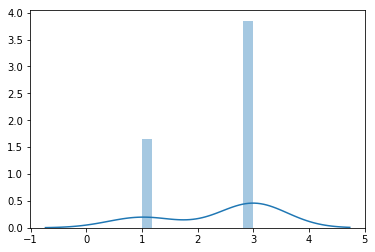

In [39]:
# diameters distribution
sns.distplot(diameters, bins=11)

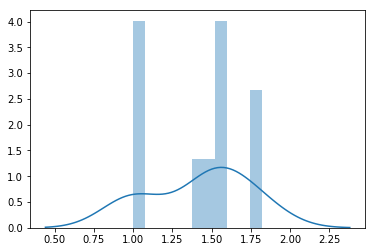

In [40]:
# Average distance distribution
sns.distplot(avg_distances, bins=11)

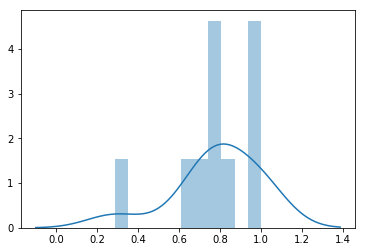

In [41]:
# clustering coefficient distribution
sns.distplot(clustering, bins=11)

## Count  the  number  the  triangles  in  the  graph,  and compare to a random graph

### Real Network

In [42]:
triangles = nx.triangles(G)
print("Total triangles", sum(triangles.values()) / 3)

Total triangles 105461.0


### Random Network

In [43]:
triangles = nx.triangles(RG)
print("Total triangles", sum(triangles.values()) / 3)

Total triangles 5857.0


## Compute and discuss other centrality measures: betweenness, PageRank

## Betweenness

### Real Network

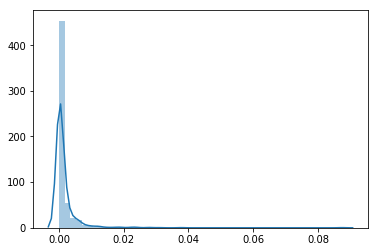

In [44]:
G = nx.read_edgelist("email-Eu-core.txt")
btw = nx.betweenness_centrality(G)
sns.distplot(list(btw.values()))

In [45]:
print("Average betweenness", np.mean(list(btw.values())))

Average betweenness 0.0015228995378930303


### Random Network

In [46]:
print(len(list(RG.edges())))

16448


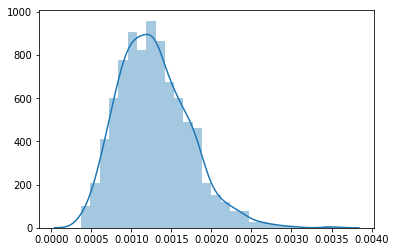

In [47]:
RG = nx.gnp_random_graph(num_nodes, p)
btw = nx.betweenness_centrality(RG)
sns.distplot(list(btw.values()))

In [48]:
print("Average betweenness", np.mean(list(btw.values())))

Average betweenness 0.0012828652454165519


## PageRank

### Real Network

In [49]:
ranks = nx.pagerank(G)
rank_values = list(ranks.values())
print("Average rank", np.mean(rank_values))

Average rank 0.0009950248756218903


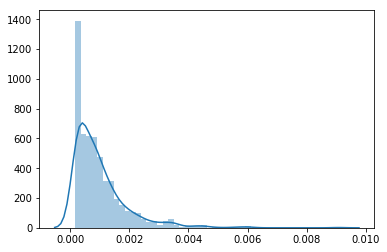

In [50]:
sns.distplot(rank_values)

### Random Network

In [51]:
ranks = nx.pagerank(RG)
rank_values = list(ranks.values())
print("Average rank", np.mean(rank_values))

Average rank 0.0009950248756218905


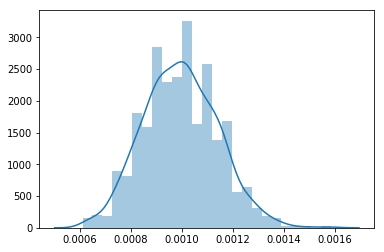

In [52]:
sns.distplot(rank_values)

## Comparative analysis of the social dataset and a non-social one
## Road Network

In [32]:
grid_G = nx.read_edgelist("out.opsahl-powergrid")
print("Number of Edges:", len(grid_G.edges()))
print("Number of Nodes:", len(grid_G.nodes()))

Number of Edges: 6594
Number of Eodes: 4941


### Degree

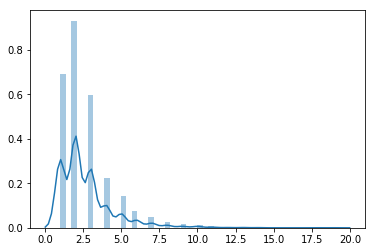

In [33]:
grid_degrees = list(map(lambda x: x[1], list(nx.degree(grid_G))))
sns.distplot(grid_degrees)

In [34]:
print("Average degree", np.mean(grid_degrees))

Average degree 2.66909532483303


### Clustering Coefficient

In [35]:
grid_G_cc_values = list(nx.clustering(grid_G).values())
avg_grid_G_cc_value = np.mean(grid_G_cc_values)
print("Average clustering coefficient", avg_grid_G_cc_value)

Average clustering coefficient 0.08010361108159712


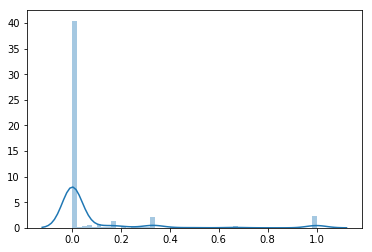

In [37]:
sns.distplot(grid_G_cc_values)

### Distance and Diameter

In [39]:
# we need to check if the graph is connected
print("Grid network is connected:", nx.is_connected(grid_G))

Grid network is connected: True


In [40]:
print("Diameter", nx.diameter(grid_G))

Diameter 46


In [41]:
paths = nx.shortest_path_length(grid_G)
total = 0
count = 0
distances = []
for node, lengths in paths:        
    values = lengths.values() 
    count += len(values) - 1 # -1 to not count the path to itself
    total += sum(values)
    distances = distances + list(values)
    
# note that we add the distance of each path twice and we also count each path twice
# Therefore when we compute total / count the result is correct
print("Average distance", total / count)

Average distance 18.989185424445708


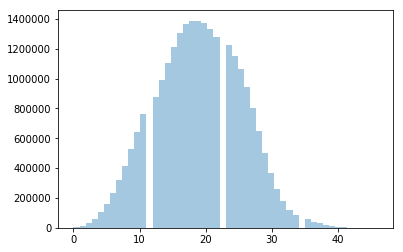

In [43]:
# note that we add the distance of each path twice and we also count each path twice
# when we plot the distribution, all the distances are normalized => the result is correct
sns.distplot(distances, kde=False)

### Degree Correlation

In [44]:
# Degree Assortativity
nx.degree_assortativity_coefficient(grid_G)

0.00345698774420483

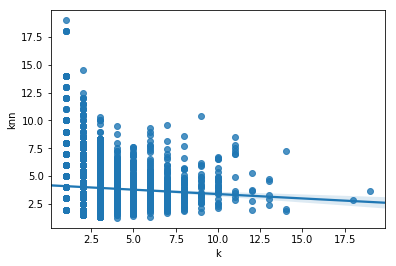

In [46]:
knns = nx.average_neighbor_degree(grid_G)
degrees = nx.degree(grid_G)
dc = []
for node in knns:
    dc.append([degrees[node], knns[node]])
data = pd.DataFrame(dc)
data.columns = ["k", "knn"]
sns.regplot(x="k", y="knn", data=data)

###  Communities Detection

In [48]:
grid_G = nx.read_edgelist("out.opsahl-powergrid")
communities = [list(c) for c in nx.algorithms.community.modularity_max.greedy_modularity_communities(grid_G)]

clustering = []
avg_distances = []
diameters = []
d = dict()
for c in communities:
    if len(c) in d:
        d[len(c)] += 1
    else:
        d[len(c)] = 1
    if len(c) > 1:
        subgraph = grid_G.subgraph(c)   
        clustering.append(nx.average_clustering(subgraph))
        avg_distances.append(nx.average_shortest_path_length(subgraph))
        diameters.append(nx.diameter(subgraph))
print("Number of communities:", len(communities))
print(d)
print("Average clusterings", clustering)
print("Average distances", avg_distances)
print("diameters", diameters)

Number of communities: 40
{338: 1, 262: 1, 261: 1, 224: 1, 202: 1, 198: 1, 197: 3, 166: 1, 164: 1, 145: 2, 137: 1, 136: 1, 131: 1, 125: 1, 123: 1, 118: 1, 114: 1, 112: 1, 110: 1, 109: 1, 105: 1, 104: 1, 98: 1, 93: 1, 78: 1, 76: 1, 72: 1, 68: 1, 66: 1, 61: 1, 42: 1, 35: 1, 33: 1, 30: 1, 29: 1, 26: 1, 14: 1}
Average clusterings [0.07571829879522186, 0.026517629952744457, 0.018780027975430276, 0.216113474818832, 0.01155115511551155, 0.09794742294742297, 0.05912496978486825, 0.02762468777697204, 0.05400048344210779, 0.015313635494358385, 0.03660472319008904, 0.13583519928347515, 0.05794934950107362, 0.018004866180048658, 0.011274509803921568, 0.13887677208287894, 0.2503114452798663, 0.062085430378113295, 0.3186083690320979, 0.018525480367585632, 0.1451754099075528, 0.05636363636363637, 0.042223678462210576, 0.28620295048866473, 0.043269230769230775, 0.006122448979591836, 0.2193036354326677, 0.0, 0.010964912280701754, 0.09351851851851851, 0.04689542483660131, 0.0562049062049062, 0.363296903

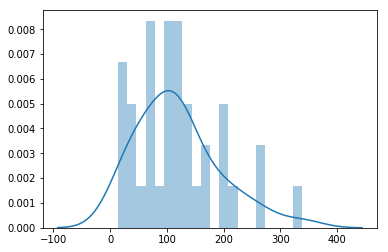

In [49]:
# size distribution
sns.distplot(list(d.keys()), bins=20)

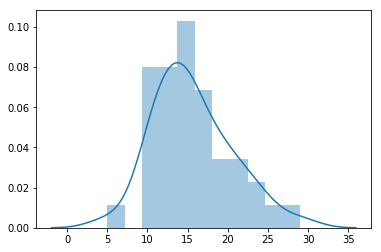

In [50]:
# diameters distribution
sns.distplot(diameters, bins=11)

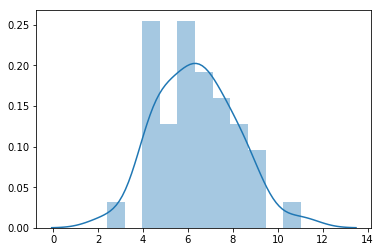

In [51]:
# Average distance distribution
sns.distplot(avg_distances, bins=11)

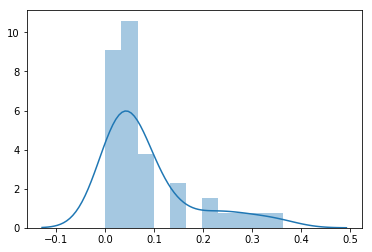

In [52]:
# clustering coefficient distribution
sns.distplot(clustering, bins=11)

### Number of Triangles

In [54]:
triangles = nx.triangles(grid_G)
print("Total triangles", sum(triangles.values()) / 3)

Total triangles 651.0


### Centrality Measures: Betweenness

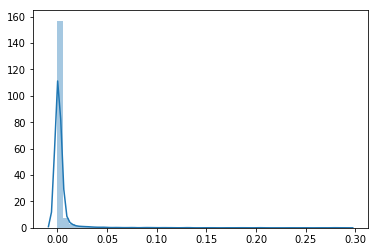

In [55]:
grid_G = nx.read_edgelist("out.opsahl-powergrid")
btw = nx.betweenness_centrality(grid_G)
sns.distplot(list(btw.values()))

In [56]:
print("Average betweenness", np.mean(list(btw.values())))

Average betweenness 0.0036422728132103135


### Centrality Measures: PageRank

In [57]:
ranks = nx.pagerank(grid_G)
rank_values = list(ranks.values())
print("Average rank", np.mean(rank_values))

Average rank 0.00020238818053025704


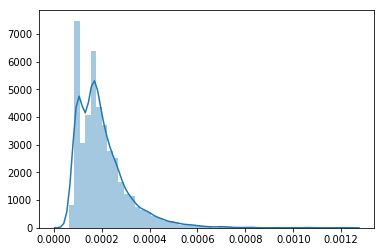

In [58]:
sns.distplot(rank_values)

# Other analysis: How to prevent the bombing?

In [2]:
G = nx.read_weighted_edgelist("out.moreno_train_train")
print("Number of terrorists", len(G.nodes()))
print("Number of contacts", len(G.edges()))

Number of terrorists 64
Number of contacts 243


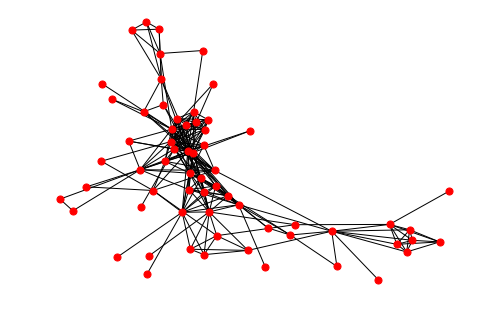

In [15]:
nx.draw(G, with_labels=False, node_size=50)

In [4]:
# convert the weight to probability to create uncertain graph
for u,v,d in G.edges(data=True):
    d['weight'] /= 4 

## Reachability and Expected Spread

In [23]:
def can_reach(G, s, t):
    Q = deque([s])
    visited = set()
    while len(Q) != 0:
        u = Q.popleft()
        if u == t:
            return 1
        visited.add(u)
        N = G.neighbors(u)
        for v in N:
            if v not in visited:
                dice = rnd.random()
                p = G[u][v]['weight']
                if dice <= p:
                    Q.append(v)
    return 0 
                        
def reachability(G,s,t,rounds=100):
    good = 0
    for i in range(rounds):
        good += can_reach(G, s, t)
    return good / rounds

In [24]:
def expected_spreads(G, num_tops = 10):
    nodes = G.nodes()
    spreads = []    
    for node1 in nodes:
        reach = 0
        for node2 in nodes:                        
            if node1 != node2:
                reach += reachability(G, node1, node2)
        spreads.append((node1, reach))
    sorted_spreads = sorted(spreads, key = lambda x: x[1], reverse=True)
    top_spreads = sorted_spreads[:num_tops]
    top_nodes = list(map(lambda x: x[0], top_spreads))
    return top_nodes

In [25]:
top_terrorists = expected_spreads(G, num_tops=3)
print(top_terrorists)

['14', '13', '15']


In [26]:
def draw_top_reachabilities_nodes(G, top_nodes):   
    color_map = []
    for node in G:
        if node in top_nodes:
            color_map.append('green')
        else: color_map.append('red')    
    nx.draw(G, node_size=50, node_color = color_map)
    plt.show()

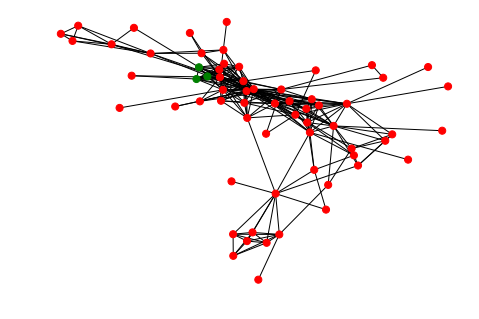

In [27]:
draw_top_reachabilities_nodes(G, top_terrorists)

## Influence Maximization

In [28]:
def can_reach_from_seeds(G, seed_nodes, t):
    Q = deque(set(seed_nodes))
    visited = set()
    while len(Q) != 0:
        u = Q.popleft()
        
        if u == t:
            return 1
        visited.add(u)
        N = G.neighbors(u)
        for v in N:
            if v not in visited:
                dice = rnd.random()
                p = G[u][v]['weight']
                if dice <= p:
                    Q.append(v)
    return 0 

def reachability_seeds(G, seed_nodes, t, rounds = 100):
    good = 0
    for i in range(rounds):
        good += can_reach_from_seeds(G, seed_nodes, t)
    return good / rounds
    

def greedyIM(G, k = 3):
    S = []
    total_spread = 0
    while len(S) < k:
        print(len(S))
        max_spread = 0
        max_u = None
        for u in G.nodes():
            m_spread = spread(G, S + [u]) - total_spread
            if m_spread > max_spread:
                max_spread = m_spread
                max_u = u
        S = S + [max_u]
        total_spread = total_spread + max_spread
    return S, total_spread

In [29]:
S, total_spread = greedyIM(G, k = 3)

0
1
2


In [30]:
print("Most Influence Nodes:",S)
print("Total spread:", total_spread)

Most Influence Nodes: ['14', '11', '10']
Total spread: 52.830000000000005


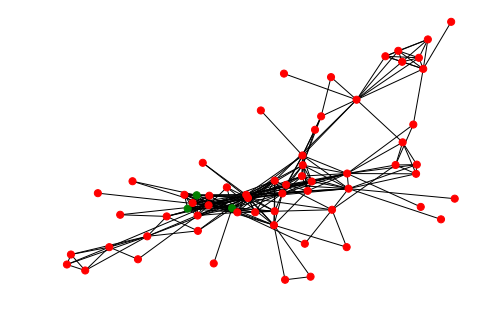

In [31]:
draw_top_reachabilities_nodes(G, S)

## Compare the spread of the terrorists return by the 2 algorithm

In [38]:
# Evaluating Reachability and Expected Spread
print("spread", spread(G, top_terrorists))

spread 52.08


In [40]:
# Greedy Influence Maximization
print("spread", total_spread)

spread 52.830000000000005
